##### Setup #####

In [142]:
#Imports
#!pip install gensim
import re
import csv
import os
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt 
import itertools
import numpy as np
import sklearn
import sklearn.linear_model
import pandas as pd
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim.models import Word2Vec
from collections import Counter
import gensim.downloader as api

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn import metrics

import pandas as pd
from sklearn.metrics import roc_curve

#tdf-idf weights
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

Load CSV file, leaving only the collumns we might be interested in.

In [143]:
''' reads data from a CSV file, filters it by type, removes duplicates and unnecessary columns, and writes the filtered data to a new CSV file.'''
##### -- Functions -- #####
def getParts(rowsCount, out):
    dropList = ['url', 'scraped_at', 'updated_at', 'title', 'authors', 'keywords', 'meta_keywords', 'tags', 'summary' ] # 'source'

    df = pd.read_csv('csvFile.csv', nrows=rowsCount)
    
    # Filter fake
    df_fake = df.loc[df['type'] == 'fake']
    df_conspiracy = df.loc[df['type'] == 'conspiracy']
    df_junksci = df.loc[df['type'] == 'junksci']
    df_hate = df.loc[df['type'] == 'hate']
    df_unreliable = df.loc[df['type'] == 'unreliable']
    df_rumor = df.loc[df['type'] == 'rumor']

    #filter reliable
    df_reliable = df.loc[df['type'] == 'reliable']
    df_political = df.loc[df['type'] == 'political']

    #Concat
    df_reliable = pd.concat([df_political, df_reliable], ignore_index=True)
    df_fake = pd.concat([df_conspiracy, df_fake, df_junksci, df_hate, df_unreliable, df_rumor], ignore_index=True)
    df_reliable['type'] = "reliable"
    df_fake['type'] = "fake"
    df_filtered = pd.concat([df_fake, df_reliable], ignore_index=True)


    # #Dublicate list
    dub = ("duplicates: ", df_filtered.duplicated(subset=['content']).sum())
    total = df_filtered.shape[0]
    percentOfDublicates = round(dub[1] / total * 100)
    print("Duplicates: " + str(percentOfDublicates) + "%")

    # Write DataFrame to CSV file
    df_filtered = df_filtered.drop(dropList, axis=1)
    df_filtered.drop_duplicates(subset=['content'], inplace=True)
    df_filtered.to_csv(out, index=False)

    ##### -- Prints -- #####
    print("Fake / reliable")
    print(df_fake.index)
    print(df_reliable.index)
    print("")
    print("loaded index")
    print(df.index)
    print("")
    print("filtered")
    print(df_filtered)
    print("")
    print("Creates a csv file called: readyData.csv")
getParts(100000, 'readyData.csv')
getParts(2000000, 'milReadyData.csv')

Duplicates: 13%
Fake / reliable
RangeIndex(start=0, stop=56316, step=1)
RangeIndex(start=0, stop=27660, step=1)

loaded index
RangeIndex(start=0, stop=100000, step=1)

filtered
       Unnamed: 0      id             domain      type  \
0              10      17  blackgenocide.org      fake   
1              11      18  blackgenocide.org      fake   
2              12      19  blackgenocide.org      fake   
3              13      20  blackgenocide.org      fake   
4              56      68  blackgenocide.org      fake   
...           ...     ...                ...       ...   
83969        7790   96593  christianpost.com  reliable   
83971        1189  101029  christianpost.com  reliable   
83972        4169  105092  christianpost.com  reliable   
83973        4440  105498  christianpost.com  reliable   
83975        9582  112137  christianpost.com  reliable   

                                                 content  \
0      \n\n\n\n\n\n\n\nRev Dr. Childress is available...   
1     

C:\Users\alx26\AppData\Local\Temp\ipykernel_4564\3040704818.py:6: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('csvFile.csv', nrows=rowsCount)


Duplicates: 55%
Fake / reliable
RangeIndex(start=0, stop=495142, step=1)
RangeIndex(start=0, stop=631016, step=1)

loaded index
RangeIndex(start=0, stop=2000000, step=1)

filtered
        Unnamed: 0       id             domain      type  \
0               10       17  blackgenocide.org      fake   
1               11       18  blackgenocide.org      fake   
2               12       19  blackgenocide.org      fake   
3               13       20  blackgenocide.org      fake   
4               56       68  blackgenocide.org      fake   
...            ...      ...                ...       ...   
1126151       5015  1226018  christianpost.com  reliable   
1126152       5017  1226020  christianpost.com  reliable   
1126153       5026  1226029  christianpost.com  reliable   
1126154       5027  1226030  christianpost.com  reliable   
1126155       5047  1226050  christianpost.com  reliable   

                                                   content  \
0        \n\n\n\n\n\n\n\nRev Dr. Chil

##### Data overview 1 #####

In [144]:
##### -- Global variables -- #####
data01 = pd.read_csv('readyData.csv')

##### -- Functions -- #####
def types(inp):
    results = inp
    results = results.dtypes
    return results

def colNames(input):
    for col in input.columns:
        print(col)

def metaNull(input):
    count = (input.isnull().sum())
    percent = count['meta_description'] / input.shape[0] * 100
    percent = round(percent)
    return percent

#####  -- prints -- #####
print("Types:")
print(types(data01))

print ('\nCount of Null: ' )
print(str(metaNull(data01)) + "%")

print ('\nshape: ' )
print(data01.shape)

print ('\nColumn names: ' )
colNames(data01)

Types:
Unnamed: 0            int64
id                    int64
domain               object
type                 object
content              object
inserted_at          object
meta_description     object
source              float64
dtype: object

Count of Null: 
76%

shape: 
(73091, 8)

Column names: 
Unnamed: 0
id
domain
type
content
inserted_at
meta_description
source


##### Preproccesing #####

Preprocceses the data, preparing it for data exploration and data proccesing.

In [146]:
##### -- Global variables -- #####
fileRaw = 'readyData.csv'

##### -- Functions -- #####
''' Creates dataframe (Run fuctions) '''
def createDataframe(input): 
    df = pd.read_csv(input)
    df = cleanContent(df, 'content')
    df = cleanContent(df, 'meta_description')
    return df

''' Cleans and tokenizes text  '''
sno = nltk.stem.SnowballStemmer('english')
def cleanContent(input, columnName):
    input[columnName] = input[columnName].astype(str) # convert non-string values to string
    input[columnName] = input[columnName].str.strip() # remove leading/trailing whitespace
    input[columnName] = input[columnName].str.lower()
    regexList = ['\.', ':', '&', ',', '\?', ' us ', '!', ';', '\$', '%', '\(', '\)', '\[', '\]']
    stop_words = set(stopwords.words('english'))
    regexList += [r'\b{}\b'.format(word) for word in stop_words]
    pattern = re.compile('|'.join(regexList))
    input[columnName] = input[columnName].apply(lambda x: pattern.sub('', x))
    input[columnName] = input[columnName].str.replace(r'\b\d+-\d+-\d+-\d+\b', 'phone', regex=True)
    input[columnName] = input[columnName].str.replace(r'https?://\S+|\bhttp://\S+', 'url', regex=True)
    input[columnName] = input[columnName].str.replace(r'\b\d+\b', 'number', regex=True)
    input[columnName] = input[columnName].str.replace(r"\b\w\b\s?\b", '', regex=True)
    input[columnName] = input[columnName].str.replace(r"['`.*@-]", '', regex=True)
    input[columnName] = input[columnName].str.replace(r'\s+', ' ', regex=True)
    for i in range(0, len(input[columnName])):
        colElm = input.at[i, columnName]
        if not colElm.isspace() and colElm != "":
            colElm = nltk.word_tokenize(colElm)
            stemmed_words = []
            for word in colElm:
                stemmed_words.append(sno.stem(word))
            stemmed_words = ' '.join(stemmed_words)
            input.at[i, columnName] = stemmed_words
    return input

'''Converts to csv File'''
def run(inp, out):
    inp = inp.to_csv(out + 'cleanedNews.csv', index = True)

##### -- Calls -- #####
run(createDataframe(fileRaw), "mil")
run(createDataframe(fileRaw), "")

KeyboardInterrupt: 

##### Data overview 2 #####

In [ ]:
##### --  Global variables -- #####
fileCleaned = 'cleanedNews.csv'

##### --  Functions -- #####
''' Creates dictionary of 100 most used times'''
def wordDic(input):
    file = open(input, 'r',  errors="surrogateescape")
    read = file.read().lower()
    words = read.split()  
    dictionary = {}
    for i in words:
        if i in dictionary:
            dictionary[i] += 1  
        else:
            dictionary[i] = 1
    sort = dict(sorted(dictionary.items(), key=lambda x: x[1], reverse=True))
    words = dict(itertools.islice(sort.items(), 100))
    return words

def something(input):
    resultList = list(wordDic(input).items())
    lst = []
    for elm in resultList:
        lst.append(elm[0])
    return lst


##### --  Prints -- #####
print("Most used words in clean and raw")
mostUsedWordsClean = (something(fileCleaned))
mostUsedWordsRaw = (something(fileRaw))
print(mostUsedWordsClean)
print(mostUsedWordsRaw)

print("\nWords that apear in both list of words:")
doubleAppearances = []
for word in mostUsedWordsClean:
    if word in mostUsedWordsRaw:
        doubleAppearances.append(word)
print(doubleAppearances)

Most used words in clean and raw
['number', '’', '“', '”', 'one', 'trump', 'state', 'peopl', 'would', 'time', 'year', 'like', 'blockchain', 'new', 'said', 'use', 'also', '–', 'report', 'make', 'get', 'go', 'next', 'even', 'two', '``', 'market', '01:19:41.756632,nan,', 'presid', 'govern', 'say', 'think', 'american', 'mani', '—', 'work', 'first', 'day', 'world', 'right', 'stock', 'nation', 'could', 'take', 'come', 'way', "''", 'need', 'may', 'know', 'search', 'see', 'bitcoin', 'call', 'want', 'sourc', 'exceed', 'fact', 'obama', 'includ', 'headlin', 'thing', 'countri', 'well', 'last', 'stori', 'news', 'much', 'support', 'back', 'hous', 'law', 'live', 'look', 'polit', 'democrat', 'good', 'unit', '‘', 'power', 'public', 'help', 'show', 'war', 'week', 'america', 'republican', 'follow', 'chang', 'made', 'life', 'group', 'part', 'end', 'person', 'inform', 'system', 'sinc', 'point', 'continu']
['the', 'of', 'to', 'and', 'a', 'in', 'is', 'that', 'for', 'on', 'are', 'as', 'with', 'it', 'this', 'b

The above code block solves the following tasks:
 - Cheks the effect of the cleaning, based on the words apearing in the most used list.

--------------------------------------------------------------------------------------------

 Converts all words to lowercase and creates a dictionary with the count of each word, and then prints the number of times specific words appear in the text.

In [ ]:
def allWordsToDic(input):
    ''' Takes all the data and converts it to a dictionary'''
    file = open(input, 'r',  errors="surrogateescape")
    read = file.read().lower()
    words = read.split()  
    dictionary = {}
    for i in words:
        if i in dictionary:
            dictionary[i] += 1  
        else:
            dictionary[i] = 1
    return dictionary

def regexpCount(decimals):
    rowCount = data01.shape[0]
    words = allWordsToDic(fileCleaned)
    number = int(words['number']) / rowCount
    phone = int(words['phone']) / rowCount
    url = int(words['url']) / rowCount
    print("number appears with a frequeny of " + str(round(number, decimals)) + " for each article")
    print("phone appears with a frequeny of " + str(round(phone, decimals)) + " for each article")
    print("url appears with a frequeny of " + str(round(url, decimals)) + " for each article")

regexpCount(3)


NameError: name 'data01' is not defined

##### Ready data for baseline model #####

In [ ]:
def split(input, out):
    # Split data
    df = pd.read_csv(input)
    
    # Creating a dataframe with 80% of the data
    part_80 = df.sample(frac = 0.8)
    part_80.to_csv((out + 'split80_train.csv'), index=False)

    # Creating a dataframe with the rest (20%)
    rest_part = df.drop(part_80.index) 
    rest_part.to_csv(out + ('split20_temp.csv'), index=False)

    # Creating a new dataframe to split the 20 % for test and validation
    df10 = pd.read_csv(out + 'split20_temp.csv')

    # Creating a dataframe with 50% of the data / 10% of the whole dataset 
    part_50 = df10.sample(frac=0.5)
    part_50.to_csv((out + 'split10_test.csv'), index=False)

    # Creating a dataframe with 50% of the data / 10% of the whole dataset 
    part_50_2 = df10.drop(part_50.index)
    part_50_2.to_csv(( out +'split10_val.csv'), index=False)

    print("\n80% of DataFrame:")
    print(part_80.shape)

    print("\n10% of DataFrame:")
    print(part_50.shape)

    print("\nrest of the 10% of DataFrame:")
    print(part_50_2.shape)

split('cleanedNews.csv', "")
split('milcleanedNews.csv', "mil")


80% of DataFrame:
(56075, 8)

10% of DataFrame:
(7010, 8)

rest of the 10% of DataFrame:
(7009, 8)

80% of DataFrame:
(56075, 8)

10% of DataFrame:
(7010, 8)

rest of the 10% of DataFrame:
(7009, 8)


Prepares the split data, such that a model can be trained.

In [ ]:
##### -- variables -- #####
train = pd.read_csv('split80_train.csv')
test = pd.read_csv('split10_test.csv')
val = pd.read_csv('split10_val.csv')

Defines several functions to vectorize text data and create binary labels based on the 'type' column, and then applies these functions to train, test, and validation datasets to create vectorized feature sets and binary labels for each dataset.

In [ ]:
##### -- Variables -- #####
lstOfWordsInWv = []
lstOfWordsNotInWv = []
vectorizer = CountVectorizer()

##### -- Functions -- #####
''' creates a binary list based on the 'type' column 
    1 == Fake and 0 == Reliable'''
def binary(inp):
    lst = []
    for i in range(0, (inp.shape[0])):
        colElm = inp.at[i, 'type']
        if colElm == 'fake':
            lst.append(1)
        else:
            lst.append(0)
    return lst

def vectorizeMeta(input): 
    lst = []
    for i in range(0, input.shape[0]): 
        elm_c = input.at [i, 'content']
        elm_m = input.at [i, 'meta_description']
        if type(elm_m) != float:
            lst.append(elm_c + elm_m)
        else:
            lst.append(elm_c)
    return(lst)

##### -- Saves -- #####
X_train_meta = vectorizer.fit_transform(vectorizeMeta(train))
X_test_meta = vectorizer.transform(vectorizeMeta(test))
X_val_meta = vectorizer.transform(vectorizeMeta(val))

X_train = vectorizer.fit_transform(train['content'])
X_test = vectorizer.transform(test['content'])
X_val = vectorizer.transform(val['content'])

y_train = binary(train)
y_val = binary(val)
y_test = binary(test)


##### Data overview 3 #####

Scatterplot


c:\Users\alx26\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\alx26\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


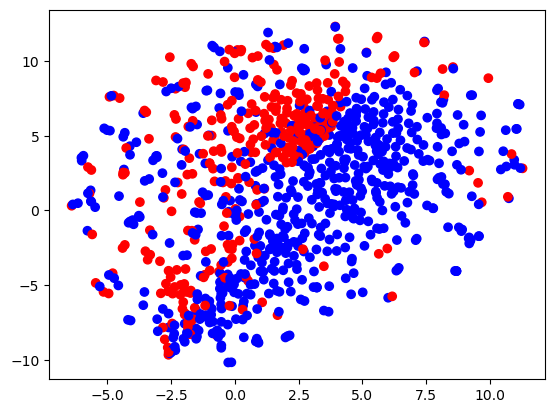

Words used for traning:
[]

Words not used for training
[]


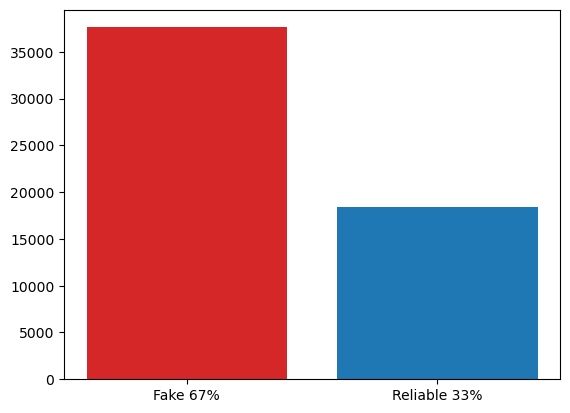

In [ ]:
##### -- functions -- #####
'''Plots the balance of the dataset'''
def balanceCheck():
    ones = 0
    zeros = 0
    for num in y_train:
        if num == 1:
            ones += 1
        elif num == 0:
            zeros += 1
    #Percentage
    total = ones + zeros
    percentOnes = round(ones/total * 100)
    percentZeros = round(zeros/total * 100)
    #Plot
    fig, ax = plt.subplots()
    labels = ['Fake ' + str(percentOnes) + '%', 'Reliable ' + str(percentZeros) + '%']
    size = [ones, zeros]
    bar_colors = ['tab:red', 'tab:blue']
    ax.bar(labels, size, label=labels, color=bar_colors)

'''Creates a scatter plot '''
def  scatterPlotOfdata(X, Y):
    tsne = TSNE(n_components=2, random_state=0)
    reduced_vectors = tsne.fit_transform(X)
    scatter_colors = ListedColormap(['red', 'blue'])
    plt.scatter(reduced_vectors[:,0], reduced_vectors[:,1], c=Y, cmap=scatter_colors)
    plt.show()
    return reduced_vectors

##### --  Prints -- #####
print("Scatterplot")
scatterPlotOfdata(X_train[:1000], y_train[:1000])
print("Words used for traning:")
print(lstOfWordsInWv[:100])
print("\nWords not used for training")
print(lstOfWordsNotInWv[:100])

balanceCheck()


t-SNE: For dimensionality reduction
Scatterplot: There doesn't seem to be any clear patterns on where the position of the points are in correlation to wheter it's fake or reliable. 

word2vec-GoogleNews-vectors is from 2016, and doesn't contain words such as blockchain and bitcoin. (reference: https://github.com/mmihaltz/word2vec-GoogleNews-vectors)


##### Baseline model #####

Baseline models with content and w/o meta_description:

In [ ]:
'''Baseline model: Logistic regression with only content'''
modelC = sklearn.linear_model.LogisticRegression(C=100, class_weight=None, solver='lbfgs', max_iter=1000)
modelC.fit(X_train, y_train) 
y_predC = modelC.predict(X_test) 

'''Baseline model: Logistic regression with both content and meta_description'''
modelM = sklearn.linear_model.LogisticRegression(C=100, class_weight=None, solver='lbfgs', max_iter=1000)
modelM.fit(X_train_meta, y_train) 
y_predM = modelM.predict(X_test_meta) 

c:\Users\alx26\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\alx26\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Printing metrics

In [ ]:
'''Logistic regression with only content'''
print("\nWithout meta_description")
print("Logistic MSE:",metrics.mean_squared_error(y_test, y_predC))
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, y_predC))
print("Logistic Regression Precision:",metrics.precision_score(y_test, y_predC))
print("Logistic Regression Recall:",metrics.recall_score(y_test, y_predC))

'''Logistic regression with both content and meta_description'''
print("\nWith meta_description")
print("Logistic MSE:",metrics.mean_squared_error(y_test, y_predM))
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, y_predM))
print("Logistic Regression Precision:",metrics.precision_score(y_test, y_predM))
print("Logistic Regression Recall:",metrics.recall_score(y_test, y_predM))




Without meta_description
Logistic MSE: 0.06947218259629101
Logistic Regression Accuracy: 0.9305278174037089
Logistic Regression Precision: 0.945877378435518
Logistic Regression Recall: 0.9509032943676939

With meta_description
Logistic MSE: 0.07089871611982881
Logistic Regression Accuracy: 0.9291012838801712
Logistic Regression Precision: 0.9425746739587716
Logistic Regression Recall: 0.9523910733262486


##### Prepare for advanced model #####

In [ ]:
trainMil = pd.read_csv('milsplit80_train.csv')
testMil = pd.read_csv('milsplit10_test.csv')
valMil = pd.read_csv('milsplit10_val.csv')

wv = api.load('word2vec-google-news-300')

In [ ]:
'''Turns a word into a 300-dimensional vector'''
def sent_vec(sent):
    vector_size = wv.vector_size
    wv_res = np.zeros(vector_size)
    ctr = 1
    for w in sent:
        if w in wv:
            lstOfWordsInWv.append(w)
            ctr += 1
            wv_res += wv[w]
        else:
            lstOfWordsNotInWv.append(w)
    wv_res = wv_res / ctr
    return wv_res

''' applies sent_vec to content and returns a list '''
def vectorizeContent(inp, col):
    return inp[col].apply(lambda x: sent_vec(x.split())).to_list()

''' applies sent_vec to meta description and returns a list '''
def vectorizeMeta(inp):
    lst = []
    for i in range(0, inp.shape[0]):
        elm = inp.at[i, 'meta_description']
        if type(elm) != float: 
            elm = sent_vec(elm.split())
            lst.append(elm)
        else:
           elm = 'NaN'
           lst.append(elm)
    return(lst)

X_train, y_train = vectorizeContent(trainMil, 'content'), binary(trainMil)
X_test, y_test = vectorizeContent(testMil, 'content'), binary(testMil)
X_val, y_val = vectorizeContent(valMil, 'content'), binary(valMil)


Scatterplot


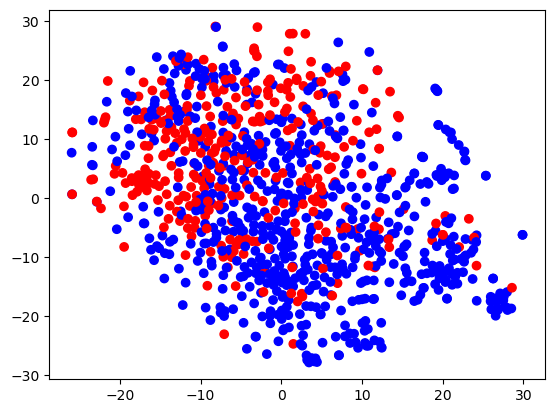

Words used for traning:
['care', 'arizona', 'law', 'bill', 'number', 'bill', 'pregnant', 'racial', 'profil', 'mandat', 'exhaust', 'session', 'examin', 'ponder', 'avail', 'person', 'cours', 'actual', 'read', 'bill', 'eye', 'follow', 'display', 'leader', 'scholarship', 'press', 'magazin', 'blog', 'general', 'word', 'street', 'presid', 'barack', 'obama', 'sign', 'number', 'page', 'health', 'care', 'bill', 'base', 'propaganda', 'gather', 'various', 'peopl', 'possess', 'incorrupt', 'eric', 'holder', 'arizona', 'law', 'issu', 'degre', 'without', 'ever', 'read', 'bill', 'instead', 'reli', 'hearsay', 'janet', 'homeland', 'secur', 'claim', 'kind', 'law', 'would', 'believ', 'bad', 'law', 'law', 'without', 'read', 'one', 'page', 'number', 'page', 'bill', 'reli', 'calcul', 'base', 'gather', 'la', 'raza', 'pamphlet', 'nation', 'view', 'proclaim', 'renown', 'expert', 'arizona', 'law', 'base', 'gather', 'must', 'proclaim', 'citi', 'san', 'francisco', 'los']

Words not used for training
['studi', 'imm

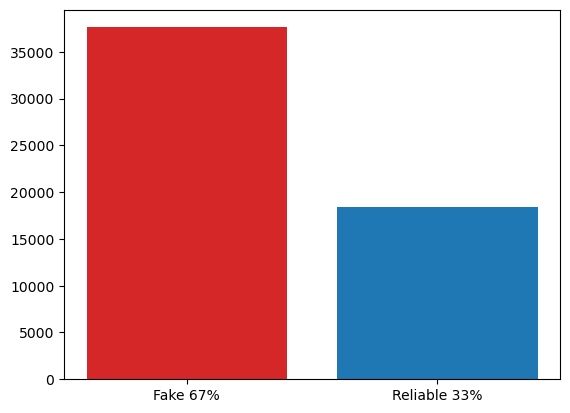

In [ ]:
##### -- functions -- #####
'''Plots the balance of the dataset'''
def balanceCheck():
    ones = 0
    zeros = 0
    for num in y_train:
        if num == 1:
            ones += 1
        elif num == 0:
            zeros += 1
    #Percentage
    total = ones + zeros
    percentOnes = round(ones/total * 100)
    percentZeros = round(zeros/total * 100)
    #Plot
    fig, ax = plt.subplots()
    labels = ['Fake ' + str(percentOnes) + '%', 'Reliable ' + str(percentZeros) + '%']
    size = [ones, zeros]
    bar_colors = ['tab:red', 'tab:blue']
    ax.bar(labels, size, label=labels, color=bar_colors)

'''Creates a scatter plot '''
def  scatterPlotOfdata(X, Y):
    tsne = TSNE(n_components=2, random_state=0)
    reduced_vectors = tsne.fit_transform(X)
    scatter_colors = ListedColormap(['red', 'blue'])
    plt.scatter(reduced_vectors[:,0], reduced_vectors[:,1], c=Y, cmap=scatter_colors)
    plt.show()
    return reduced_vectors

##### --  Prints -- #####
print("Scatterplot")
scatterPlotOfdata(X_train[:1000], y_train[:1000])
print("Words used for traning:")
print(lstOfWordsInWv[:100])
print("\nWords not used for training")
print(lstOfWordsNotInWv[:100])

balanceCheck()

In [ ]:
##### Variables #####
df_lair = pd.read_csv('test.tsv', sep = '\t', header = None)

''' Converts statement into a list of word vectors '''
def LairToListX(input):
    df = (cleanContent(input, 2))
    lst = vectorizeContent(df, 2)
    return lst

''' Converts label into binary list '''
def binaryLair(inp):
    lst = []
    for i in range(0, (inp.shape[0])):
        colElm = inp.at[i, 1]
        if colElm == 'true' or colElm == 'mostly-true':
            lst.append(0)
        else:
            lst.append(1)
    return lst

lairX_test = LairToListX(df_lair)
lairY_test = binaryLair(df_lair)

NameError: name 'cleanContent' is not defined

##### Advanced model #####

In [ ]:
''' Grid search '''
def gridSearchAdv():
    hyperparameters = {'n_estimators': [100, 10, 1.0, 0.1, 0.01], 
                       'learning_rate': [100, 10, 1.0, 0.1, 0.01], 
                       'max_depth': [1, 3, 4]}
    grid_search = GridSearchCV(sklearn.ensemble.GradientBoostingClassifier(), hyperparameters, cv=5, scoring='accuracy')
    grid_search.fit(X_val, y_val)
    print('Best hyperparameters:', grid_search.best_params_)
    print('Accuracy:', grid_search.best_score_)
#gridSearchAdv()


gridSearchAdv: <br>
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}<br>
Accuracy: 0.80682312715291


Gradient Boosting Classifier

In [ ]:
from sklearn import ensemble

model = sklearn.ensemble.GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test) #With original dataset
lair_pred = model.predict(lairX_test) #With Liar dataset 


NameError: name 'lairX_test' is not defined

GradientBoostingClassifier MSE: 0.16390870185449358
GradientBoostingClassifier Accuracy: 0.8360912981455064
GradientBoostingClassifier Precision: 0.8513833992094861
GradientBoostingClassifier Recall: 0.9156216790648246
GradientBoostingClassifier F1-Score: 0.7946871952807855
[falsePositive, truePositive, trueNegative, falseNegative] = [752, 4308, 1553, 397]


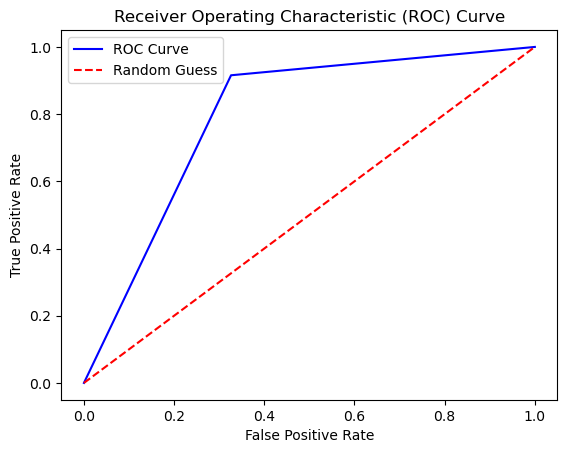


GradientBoostingClassifier MSE: 0.5769534333070244
GradientBoostingClassifier Accuracy: 0.4230465666929755
GradientBoostingClassifier Precision: 0.629080118694362
GradientBoostingClassifier Recall: 0.2591687041564792
GradientBoostingClassifier F1-Score: 0.49038613381543333
[falsePositive, truePositive, trueNegative, falseNegative] = [125, 212, 324, 606]


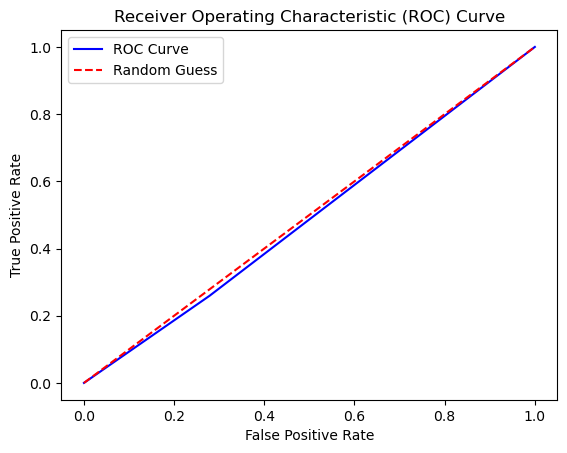

In [ ]:
def truthTable(lstTrue, lstPred):
    falsePositive = 0
    truePositive = 0
    trueNegative = 0
    falseNegative = 0
    for i in range (0, len(lstTrue)):
        if lstTrue[i] == 0 and lstPred[i] == 1: falsePositive += 1
        elif lstTrue[i] == 1 and lstPred[i] == 1: truePositive += 1
        elif lstTrue[i] == 0 and lstPred[i] == 0: trueNegative += 1
        elif lstTrue[i] == 1 and lstPred[i] == 0: falseNegative += 1
    return [falsePositive, truePositive, trueNegative, falseNegative]

def plotRocCurve(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)

    # Plot the ROC curve
    plt.plot(fpr, tpr, color='blue', label='ROC Curve')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

##### -- Fake news corpus -- #####
print("GradientBoostingClassifier MSE:",metrics.mean_squared_error(y_test, y_pred))
print("GradientBoostingClassifier Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("GradientBoostingClassifier Precision:",metrics.precision_score(y_test, y_pred))
print("GradientBoostingClassifier Recall:",metrics.recall_score(y_test, y_pred))
print("GradientBoostingClassifier F1-Score:",metrics.recall_score(y_test, y_pred, average='macro'))
print("[falsePositive, truePositive, trueNegative, falseNegative] = " + str(truthTable(y_test, y_pred)))
plotRocCurve(y_test, y_pred)

##### -- Lair dataset -- #####
print("\nGradientBoostingClassifier MSE:",metrics.mean_squared_error(lairY_test, lair_pred))
print("GradientBoostingClassifier Accuracy:",metrics.accuracy_score(lairY_test, lair_pred))
print("GradientBoostingClassifier Precision:",metrics.precision_score(lairY_test, lair_pred))
print("GradientBoostingClassifier Recall:",metrics.recall_score(lairY_test, lair_pred))
print("GradientBoostingClassifier F1-Score:",metrics.recall_score(lairY_test, lair_pred, average='macro'))
print("[falsePositive, truePositive, trueNegative, falseNegative] = " + str(truthTable(lairY_test, lair_pred)))
plotRocCurve(lairY_test, lair_pred)

##### Evaluation #####

In [ ]:
print(list(data01.columns))
print(data01['domain'])

def getDomains(data, inp):
    df = data
    df2 = df[df['type'] == inp]['domain']
    return df2

def countDomain(input):
    domain = input
    dictionary = {}
    for i in domain:
        if i in dictionary:
            dictionary[i] += 1  
        else:
            dictionary[i] = 1
    sort = dict(sorted(dictionary.items(), key=lambda x: x[1], reverse=True))
    return dict(itertools.islice(sort.items(), 10))

print("Reliable")
Domain_reliable = getDomains(data01, "fake")
Domain_fake = getDomains(data01, "reliable")

print(Domain_reliable)

print(countDomain(Domain_reliable))
print(countDomain(Domain_fake))


['Unnamed: 0', 'id', 'domain', 'type', 'content', 'inserted_at', 'meta_description', 'source']
0        blackgenocide.org
1        blackgenocide.org
2        blackgenocide.org
3        blackgenocide.org
4        blackgenocide.org
               ...        
73086    christianpost.com
73087    christianpost.com
73088    christianpost.com
73089    christianpost.com
73090    christianpost.com
Name: domain, Length: 73091, dtype: object
Reliable
0        blackgenocide.org
1        blackgenocide.org
2        blackgenocide.org
3        blackgenocide.org
4        blackgenocide.org
               ...        
50055        express.co.uk
50056        express.co.uk
50057        express.co.uk
50058        express.co.uk
50059        express.co.uk
Name: domain, Length: 50060, dtype: object
{'beforeitsnews.com': 41822, 'canadafreepress.com': 2634, 'naturalnews.com': 1085, 'awarenessact.com': 583, 'collectivelyconscious.net': 433, '21stcenturywire.com': 326, 'endoftheamericandream.com': 288, 'theeconomic